# Diagnosis Prediction with Naive Bayes

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from naive_bayes import NaiveBayes, balance_classes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
sns.set_style("darkgrid")

# Basic EDA

In [2]:
data = pd.read_csv("data.csv")
data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


<Axes: >

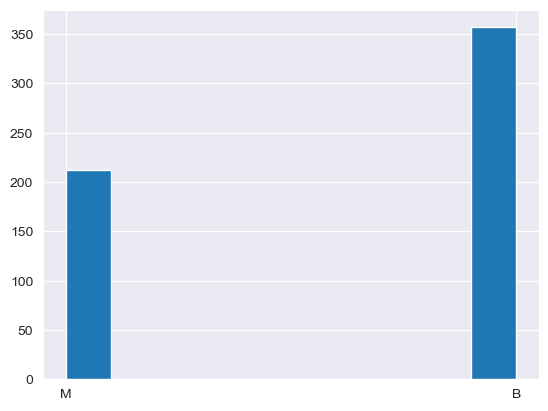

In [3]:
# Data are slightly imbalanced, will balance out before training
data["diagnosis"].hist()

<Axes: >

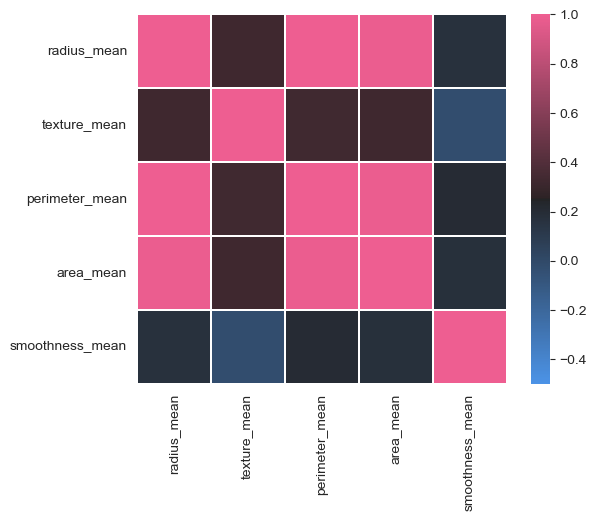

In [4]:
# We need to ensure the features we train on are independent, let's check
features = ['radius_mean', 'texture_mean','perimeter_mean','area_mean','smoothness_mean']
data_feats = data[features].copy()
corr = data_feats.corr(method="pearson") # ignore Unnamed 32 column
cmap = sns.diverging_palette(250,354,80,60, 
                             center='dark', as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-0.5, cmap=cmap, square=True, linewidths=0.2)

Observation:
- Radius, perimeter, and area are highly correlated (they are linearly dependent).
- We will choose texture, smoothness, and one of the above, let's go with radius

In [5]:
# Drop dependent features
data_feats.drop(columns=[
    'perimeter_mean',
    'area_mean',
    ])

# Add diagnosis, but as bool 
data_feats.loc[:,'diagnosis'] = np.where(data.loc[:,'diagnosis']=="B",0,1)

In [6]:
data_feats

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,1
1,20.57,17.77,132.90,1326.0,0.08474,1
2,19.69,21.25,130.00,1203.0,0.10960,1
3,11.42,20.38,77.58,386.1,0.14250,1
4,20.29,14.34,135.10,1297.0,0.10030,1
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,1
565,20.13,28.25,131.20,1261.0,0.09780,1
566,16.60,28.08,108.30,858.1,0.08455,1
567,20.60,29.33,140.10,1265.0,0.11780,1


<Axes: xlabel='texture_mean', ylabel='Count'>

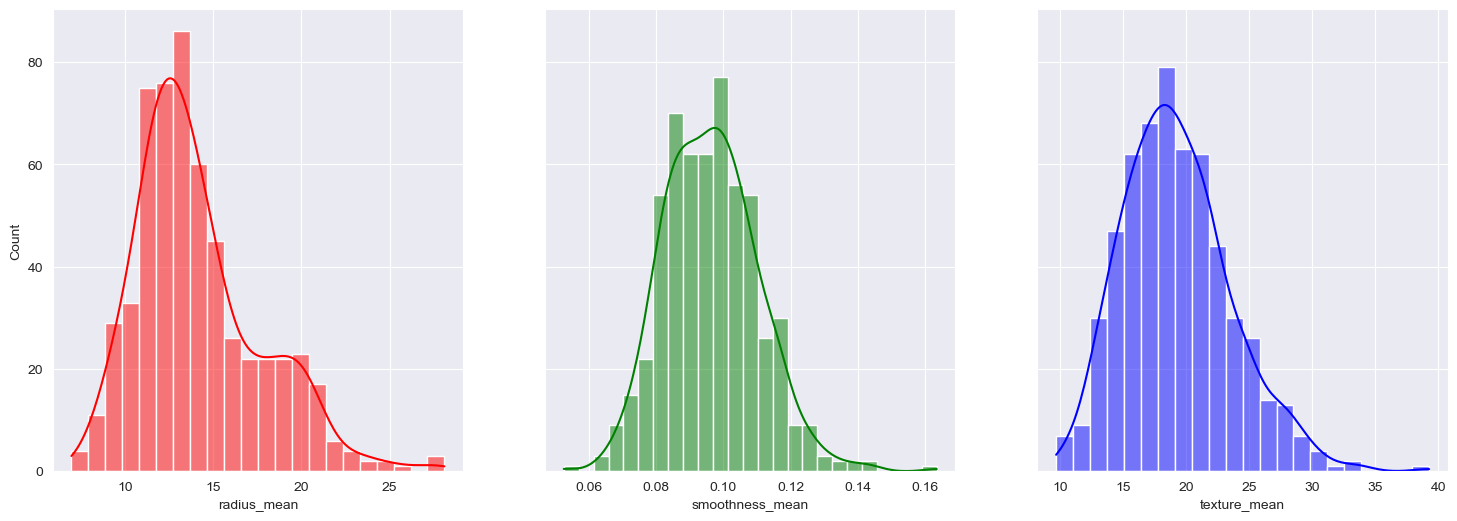

In [7]:
# The features are mostly normally distributed
fig, axes = plt.subplots(1,3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="radius_mean", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="smoothness_mean", kde=True, color='g')
sns.histplot(data, ax=axes[2], x="texture_mean", kde=True, color='b')

# Balance the classes, then split the data

There are 357 benign datapoints and 212 malignant datapoints.
Classes balanced successfully.


<Axes: >

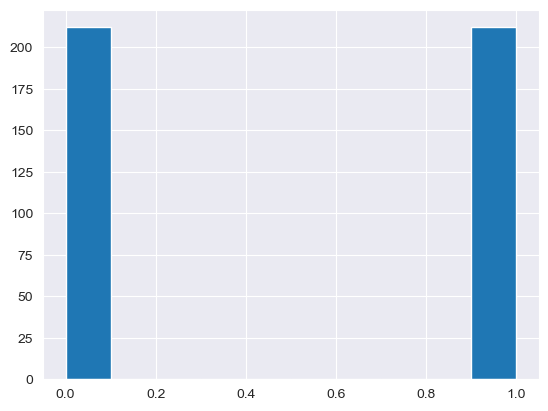

In [10]:
data_balanced = balance_classes(data_feats)
data_balanced["diagnosis"].hist()

In [31]:
train, test = train_test_split(data_balanced, test_size=0.3, random_state=42)

# Split X and y
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values

# Predict classes

0.859375


Text(0.5, 1.0, 'Naive Bayes Prediction, F1-Score: 0.859375')

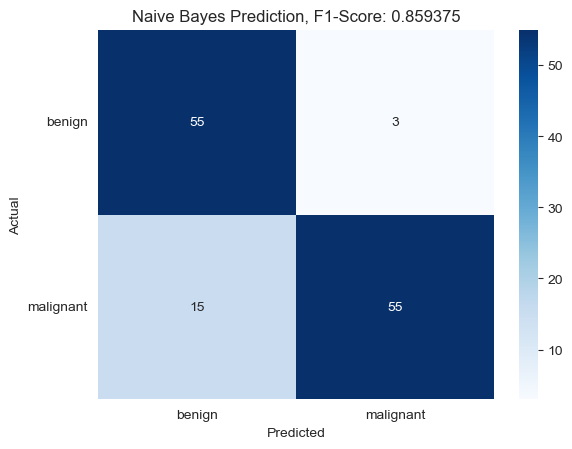

In [56]:
nb = NaiveBayes()
nb.fit(X=X_train, y=y_train)

y_pred = nb.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
f1=f1_score(y_test, y_pred)
print(f1)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xticks(ticks=[0.5, 1.5], labels=["benign", "malignant"], rotation=0)
plt.yticks(ticks=[0.5, 1.5], labels=["benign", "malignant"], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Naive Bayes Prediction, F1-Score: {f1}")